1) Configuración y carga

In [5]:
# --- CONFIG ---
DATA_PATH = Path("..") / "DataBase" / "Churn_Modelling.csv"
TARGET = "Exited"

# --- IMPORTS ---
import os, json, math, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear carpeta de salidas
OUT = "eda_outputs"
os.makedirs(OUT, exist_ok=True)

# --- LECTURA ---
df = pd.read_csv(DATA_PATH)

print("=== SHAPE ===")
print(df.shape)
print("\n=== COLUMNAS ===")
print(df.columns.tolist())

# Normaliza nombres
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Asegura el nombre del target
assert TARGET in df.columns, f"Target '{TARGET}' no encontrado. Columnas: {df.columns.tolist()}"

# Vista rápida
display(df.head())

=== SHAPE ===
(10000, 14)

=== COLUMNAS ===
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


2) Tipos, nulos, duplicados, variables tipo ID

In [6]:
# Tipos y nulos
dtypes = df.dtypes.astype(str)
nulls = df.isna().sum()
dups = df.duplicated().sum()

print("=== DTYPES ===\n", dtypes, "\n")
print("=== NULOS ===\n", nulls, "\n")
print("=== DUPLICADOS ===", dups)

# Variables tipo ID por heurística
id_candidates = [c for c in df.columns if any(k in c.lower() for k in ["id","row","surname","name","customer"])]
print("\n=== POSIBLES ID A DESCARTAR ===", id_candidates)

# Guardar
dtypes.to_csv(f"{OUT}/dtypes.csv")
nulls.to_csv(f"{OUT}/nulls.csv")
pd.Series(id_candidates, name="id_candidates").to_csv(f"{OUT}/id_candidates.csv", index=False)

=== DTYPES ===
 RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object 

=== NULOS ===
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64 

=== DUPLICADOS === 0

=== POSIBLES ID A DESCARTAR === ['RowNumber', 'CustomerId', 'Surname']


3) Separación numéricas / categóricas y limpieza rápida

In [7]:
# Detecta numéricas y categóricas (por dtype)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# No trates el TARGET como predictor
num_cols = [c for c in num_cols if c != TARGET]
cat_cols = [c for c in cat_cols if c != TARGET]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Limpieza soft: trim strings en categóricas
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()

# Chequeo de cardinalidad
card = df[cat_cols].nunique().sort_values(ascending=False) if cat_cols else pd.Series(dtype=int)
print("\nCardinalidad categóricas:\n", card)
card.to_csv(f"{OUT}/categorical_cardinality.csv")

# Clases del target
print("\n=== DISTRIBUCIÓN DEL TARGET ===")
print(df[TARGET].value_counts())
print(df[TARGET].value_counts(normalize=True))

Numéricas: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categóricas: ['Surname', 'Geography', 'Gender']

Cardinalidad categóricas:
 Surname      2932
Geography       3
Gender          2
dtype: int64

=== DISTRIBUCIÓN DEL TARGET ===
Exited
0    7963
1    2037
Name: count, dtype: int64
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


4) Resumen numérico y outliers (IQR)

In [8]:
desc = df[num_cols + [TARGET]].describe().T if num_cols else pd.DataFrame()
desc.to_csv(f"{OUT}/numeric_describe.csv")
display(desc)

# Outliers por IQR
def iqr_outlier_counts(s: pd.Series, k=1.5):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - k*iqr; hi = q3 + k*iqr
    return int(((s < lo) | (s > hi)).sum())

outlier_counts = []
for c in num_cols:
    outlier_counts.append({"column": c, "iqr_outliers": iqr_outlier_counts(df[c].dropna())})
outlier_df = pd.DataFrame(outlier_counts).sort_values("iqr_outliers", ascending=False)
display(outlier_df)
outlier_df.to_csv(f"{OUT}/iqr_outliers.csv", index=False)

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


,column,iqr_outliers
3,Age,359
6,NumOfProducts,60
2,CreditScore,15
0,RowNumber,0
1,CustomerId,0
4,Tenure,0
5,Balance,0
7,HasCrCard,0
8,IsActiveMember,0
9,EstimatedSalary,0


5) Correlación numérica con el target y entre numéricas

=== |corr| con target ===


Age                0.285323
IsActiveMember     0.156128
Balance            0.118533
NumOfProducts      0.047820
CreditScore        0.027094
RowNumber          0.016571
Tenure             0.014001
EstimatedSalary    0.012097
HasCrCard          0.007138
CustomerId         0.006248
Name: Exited, dtype: float64

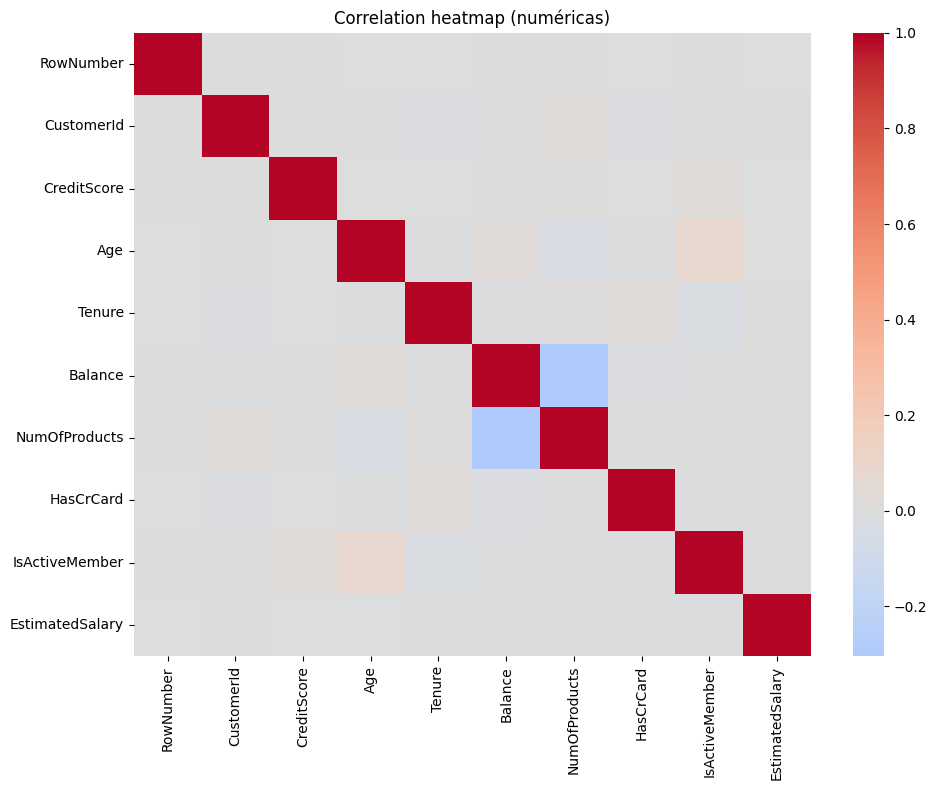

In [9]:
# Correlación numérica con target
corr_with_y = df[num_cols + [TARGET]].corr(numeric_only=True)[TARGET].drop(TARGET).abs().sort_values(ascending=False)
print("=== |corr| con target ===")
display(corr_with_y)
corr_with_y.to_csv(f"{OUT}/corr_with_target.csv")

# Heatmap de correlaciones entre numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation heatmap (numéricas)")
plt.tight_layout()
plt.savefig(f"{OUT}/corr_heatmap_num.png", dpi=160)
plt.show()

6) Cramér’s V para categóricas vs target y mutual information

In [10]:
import scipy.stats as ss

def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(ct)[0]
    n = ct.sum().sum()
    phi2 = chi2 / n
    r, k = ct.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))) if min((kcorr-1),(rcorr-1))>0 else 0.0

cramers_list = []
for c in cat_cols:
    v = cramers_v(df[c], df[TARGET])
    cramers_list.append((c, v))
cramers_df = pd.DataFrame(cramers_list, columns=["feature","cramers_v"]).sort_values("cramers_v", ascending=False)
display(cramers_df)
cramers_df.to_csv(f"{OUT}/cramers_v_cat_vs_target.csv", index=False)

# Mutual information (mezcla num/cat automáticamente si las codificamos)
X_for_mi = df[num_cols].copy()
for c in cat_cols:
    X_for_mi[c] = LabelEncoder().fit_transform(df[c].astype(str))

mi = mutual_info_classif(X_for_mi, df[TARGET], random_state=0, discrete_features=[X_for_mi[c].dtype!=float for c in X_for_mi.columns])
mi_s = pd.Series(mi, index=X_for_mi.columns).sort_values(ascending=False)
display(mi_s)
mi_s.to_csv(f"{OUT}/mutual_information.csv")

,feature,cramers_v
1,Geography,0.172999
2,Gender,0.105797
0,Surname,0.000000


RowNumber          0.505489
CustomerId         0.505489
Surname            0.151359
Age                0.074316
NumOfProducts      0.069953
CreditScore        0.026719
Geography          0.014017
IsActiveMember     0.012291
Balance            0.008269
Gender             0.005652
EstimatedSalary    0.002704
Tenure             0.000703
HasCrCard          0.000025
dtype: float64

7) Tasas de churn por categorías y por bins

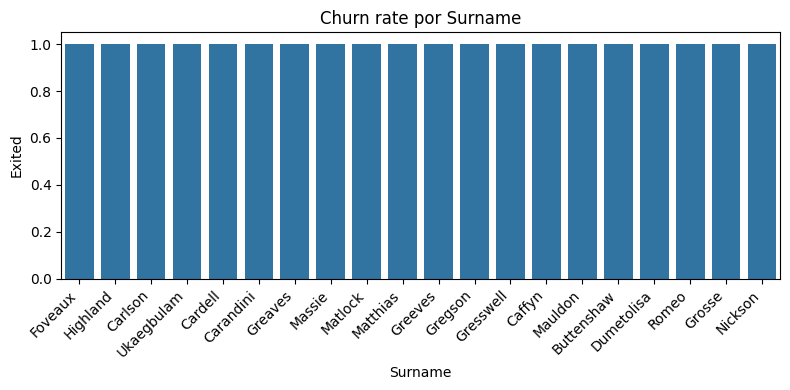

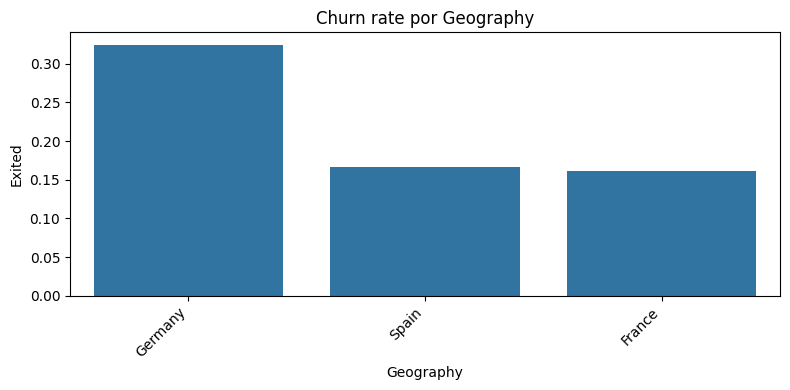

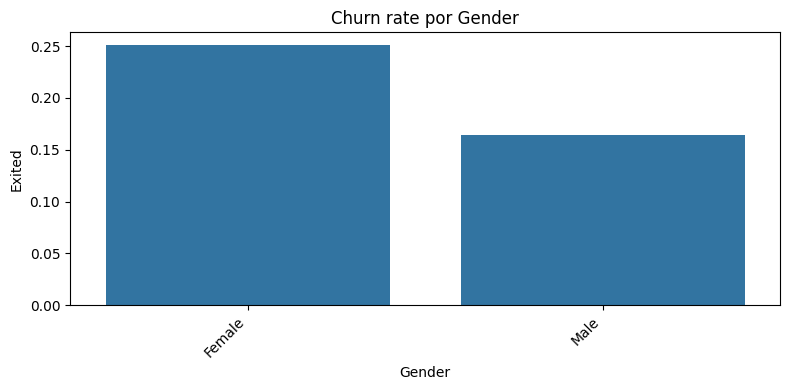

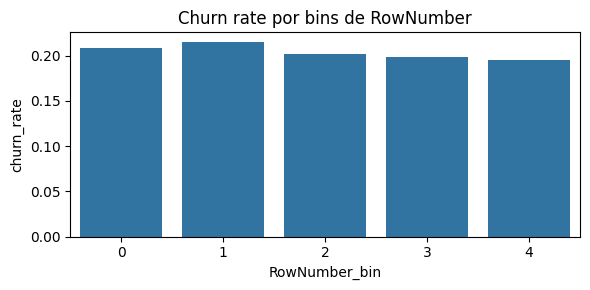

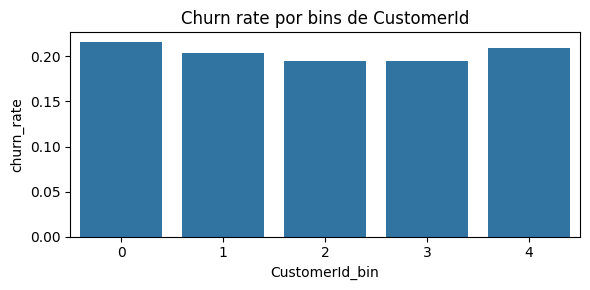

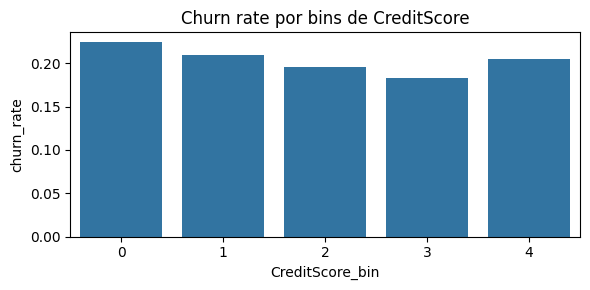

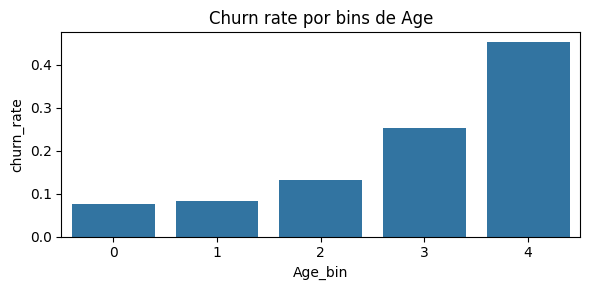

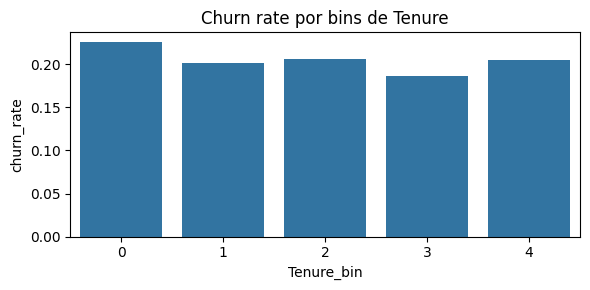

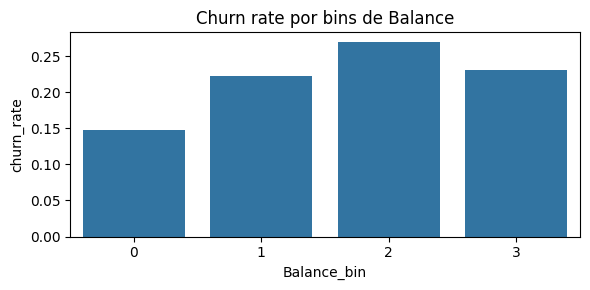

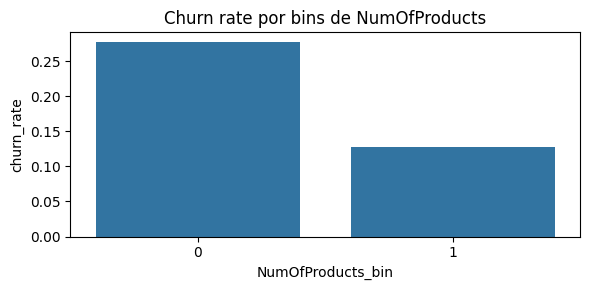

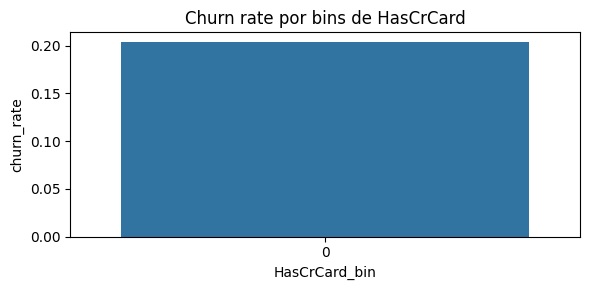

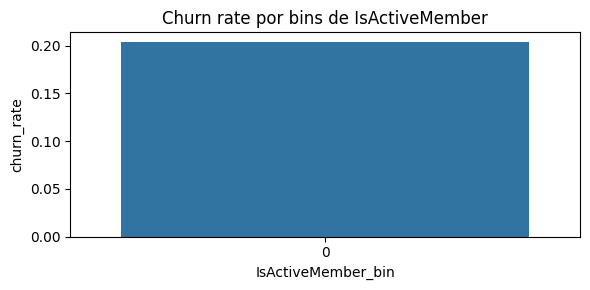

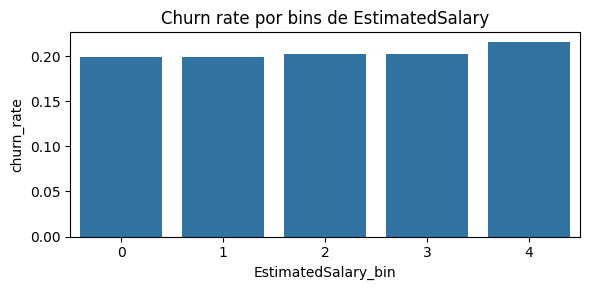

In [ ]:
def churn_rate_by_category(df, col, target=TARGET, top_n=20):
    tmp = (df.groupby(col)[target]
           .mean()
           .sort_values(ascending=False)
           .reset_index())
    if len(tmp) > top_n:
        tmp = tmp.head(top_n)
    plt.figure(figsize=(8, 4))
    sns.barplot(data=tmp, x=col, y=target)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Churn rate por {col}")
    plt.tight_layout()
    plt.savefig(f"{OUT}/churn_rate_{col}.png", dpi=160)
    plt.show()
    return tmp

# Por todas las categóricas
cat_tables = {}
for c in cat_cols:
    cat_tables[c] = churn_rate_by_category(df, c)
    cat_tables[c].to_csv(f"{OUT}/churn_rate_by_{c}.csv", index=False)

# Bins para numéricas (5 cuartiles ≈ KBins quantile)
for c in num_cols:
    try:
        kb = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
        b = kb.fit_transform(df[[c]])
        df[f"{c}_bin"] = b.astype(int)
        ct = df.groupby(f"{c}_bin")[TARGET].mean().reset_index().rename(columns={TARGET:"churn_rate"})
        ct.to_csv(f"{OUT}/churn_rate_by_{c}_bin.csv", index=False)

        plt.figure(figsize=(6,3))
        sns.barplot(data=ct, x=f"{c}_bin", y="churn_rate")
        plt.title(f"Churn rate por bins de {c}")
        plt.tight_layout()
        plt.savefig(f"{OUT}/churn_rate_bins_{c}.png", dpi=160)
        plt.show()
    except Exception as e:
        print(f"[WARN] No pude binnear {c}: {e}")

In [12]:
from IPython.display import display, HTML

def wilson_ci(k, n, z=1.96):
    """Intervalo de confianza 95% (Wilson) para proporciones, vectorizado."""
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    phat = k / np.where(n == 0, np.nan, n)
    denom = 1.0 + (z**2)/np.where(n == 0, np.nan, n)
    center = (phat + (z**2)/(2*n)) / denom
    margin = z * np.sqrt((phat*(1-phat) + (z**2)/(4*n)) / n) / denom
    return center - margin, center + margin

In [13]:
def churn_rate_by_category(df, col, target=TARGET, top_n=20):
    g = df.groupby(col)[target]
    out = pd.DataFrame({
        col: g.mean().index,
        "n": g.count().values,
        "churners": g.sum().values,
        "rate": g.mean().values
    })
    lo, hi = wilson_ci(out["churners"], out["n"])
    out["ci95_low"] = lo
    out["ci95_high"] = hi
    out["rate_%"] = (100*out["rate"]).round(2)
    out = out.sort_values("rate", ascending=False)
    if len(out) > top_n:
        out = out.head(top_n)

    # === TABLA EN PANTALLA ===
    display(HTML(f"<h3>Churn rate por {col}</h3>"))
    display(out.reset_index(drop=True))

    # === GRÁFICO ===
    plt.figure(figsize=(8, 4))
    sns.barplot(data=out, x=col, y="rate")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Churn rate por {col}")
    plt.tight_layout()
    plt.savefig(f"{OUT}/churn_rate_{col}.png", dpi=160)
    plt.show()

    # === EXPORTA CSV ===
    out.to_csv(f"{OUT}/churn_rate_by_{col}.csv", index=False)
    return out

In [14]:
def churn_rate_by_numeric_bins(df, col, target=TARGET, q=5):
    # Bins por cuantiles con etiquetas de intervalo
    bins = pd.qcut(df[col], q=q, duplicates="drop")
    tmp = df.copy()
    tmp[f"{col}_bin"] = bins

    g = tmp.groupby(f"{col}_bin")[target]
    out = pd.DataFrame({
        f"{col}_bin": g.mean().index.astype(str),
        "n": g.count().values,
        "churners": g.sum().values,
        "rate": g.mean().values
    })
    lo, hi = wilson_ci(out["churners"], out["n"])
    out["ci95_low"] = lo
    out["ci95_high"] = hi
    out["rate_%"] = (100*out["rate"]).round(2)

    # === TABLA EN PANTALLA ===
    display(HTML(f"<h3>Churn rate por bins de {col}</h3>"))
    display(out)

    # === GRÁFICO ===
    plt.figure(figsize=(6, 3))
    sns.barplot(data=out, x=f"{col}_bin", y="rate")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Churn rate por bins de {col}")
    plt.tight_layout()
    plt.savefig(f"{OUT}/churn_rate_bins_{col}.png", dpi=160)
    plt.show()

    # === EXPORTA CSV ===
    out.to_csv(f"{OUT}/churn_rate_by_{col}_bin.csv", index=False)
    return out

,Surname,n,churners,rate,ci95_low,ci95_high,rate_%
0,Foveaux,1,1,1.0,0.206543,1.0,100.0
1,Highland,1,1,1.0,0.206543,1.0,100.0
2,Carlson,1,1,1.0,0.206543,1.0,100.0
3,Ukaegbulam,1,1,1.0,0.206543,1.0,100.0
4,Cardell,1,1,1.0,0.206543,1.0,100.0
5,Carandini,1,1,1.0,0.206543,1.0,100.0
6,Greaves,1,1,1.0,0.206543,1.0,100.0
7,Massie,2,2,1.0,0.342372,1.0,100.0
8,Matlock,1,1,1.0,0.206543,1.0,100.0
9,Matthias,1,1,1.0,0.206543,1.0,100.0


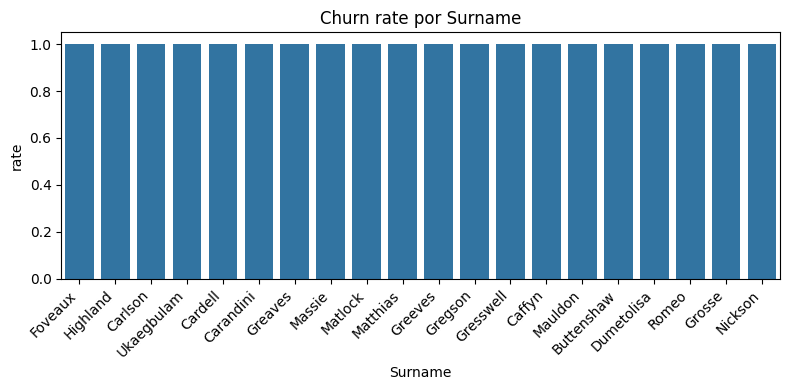

,Geography,n,churners,rate,ci95_low,ci95_high,rate_%
0,Germany,2509,814,0.324432,0.306393,0.343007,32.44
1,Spain,2477,413,0.166734,0.152573,0.181927,16.67
2,France,5014,810,0.161548,0.151620,0.171993,16.15


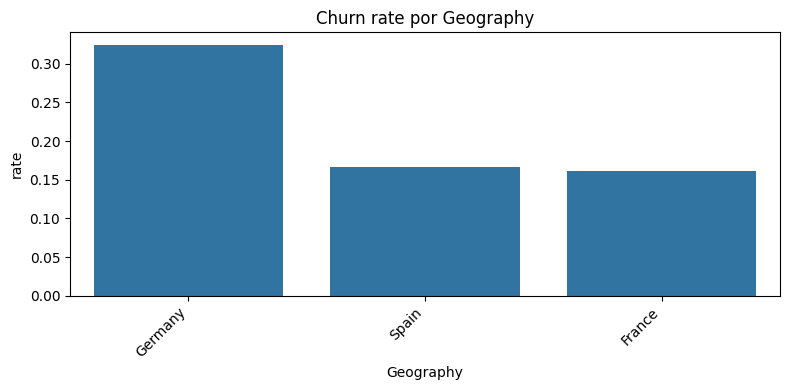

,Gender,n,churners,rate,ci95_low,ci95_high,rate_%
0,Female,4543,1139,0.250715,0.238326,0.263526,25.07
1,Male,5457,898,0.164559,0.154958,0.174632,16.46


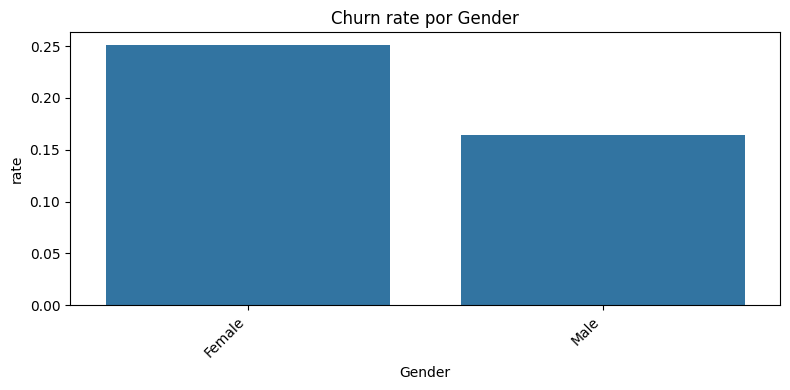

,RowNumber_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(0.999, 2000.8]",2000,416,0.2080,0.190780,0.226340,20.80
1,"(2000.8, 4000.6]",2000,430,0.2150,0.197550,0.233542,21.50
2,"(4000.6, 6000.4]",2000,403,0.2015,0.184500,0.219645,20.15
3,"(6000.4, 8000.2]",2000,398,0.1990,0.182086,0.217068,19.90
4,"(8000.2, 10000.0]",2000,390,0.1950,0.178227,0.212942,19.50


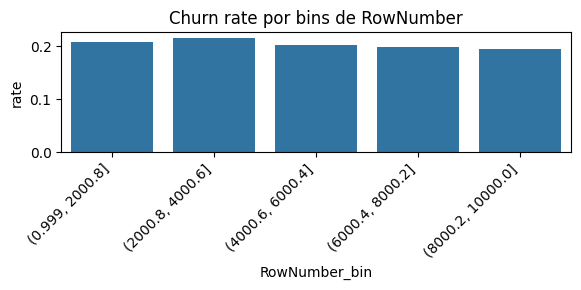

,CustomerId_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(15565700.999, 15616377.4]",2000,432,0.2160,0.198518,0.234571,21.60
1,"(15616377.4, 15665787.6]",2000,407,0.2035,0.186431,0.221705,20.35
2,"(15665787.6, 15715686.6]",2000,390,0.1950,0.178227,0.212942,19.50
3,"(15715686.6, 15765818.8]",2000,390,0.1950,0.178227,0.212942,19.50
4,"(15765818.8, 15815690.0]",2000,418,0.2090,0.191746,0.227369,20.90


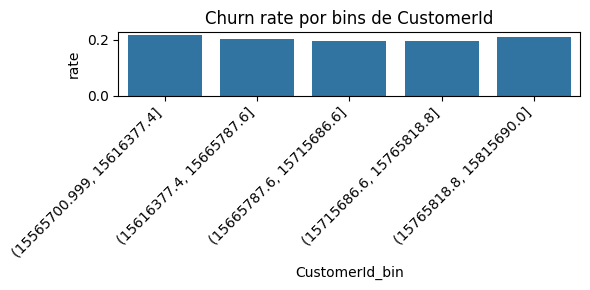

,CreditScore_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(349.999, 566.0]",2010,452,0.224876,0.207158,0.243643,22.49
1,"(566.0, 627.0]",2020,421,0.208416,0.191264,0.226674,20.84
2,"(627.0, 678.0]",2010,395,0.196517,0.179731,0.214461,19.65
3,"(678.0, 735.0]",1981,363,0.183241,0.166823,0.200885,18.32
4,"(735.0, 850.0]",1979,406,0.205154,0.187942,0.223509,20.52


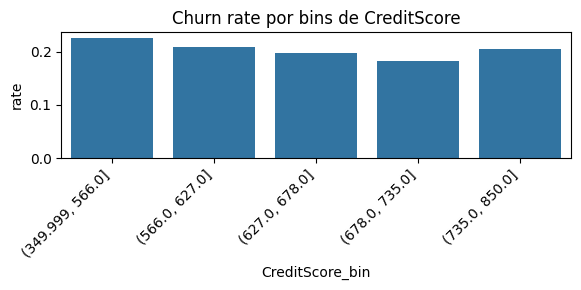

,Age_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(17.999, 31.0]",2372,181,0.076307,0.066294,0.087690,7.63
1,"(31.0, 35.0]",1781,166,0.093206,0.080566,0.107598,9.32
2,"(35.0, 40.0]",2266,339,0.149603,0.135510,0.164882,14.96
3,"(40.0, 46.0]",1696,485,0.285967,0.264964,0.307938,28.60
4,"(46.0, 92.0]",1885,866,0.459416,0.437024,0.481974,45.94


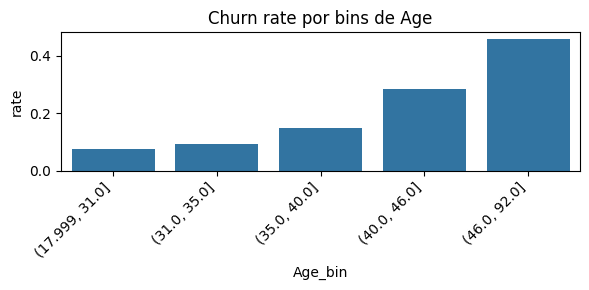

,Tenure_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(-0.001, 2.0]",2496,528,0.211538,0.195966,0.227998,21.15
1,"(2.0, 4.0]",1998,416,0.208208,0.190973,0.226564,20.82
2,"(4.0, 6.0]",1979,405,0.204649,0.187454,0.222988,20.46
3,"(6.0, 8.0]",2053,374,0.182172,0.166074,0.199458,18.22
4,"(8.0, 10.0]",1474,314,0.213026,0.192883,0.234661,21.30


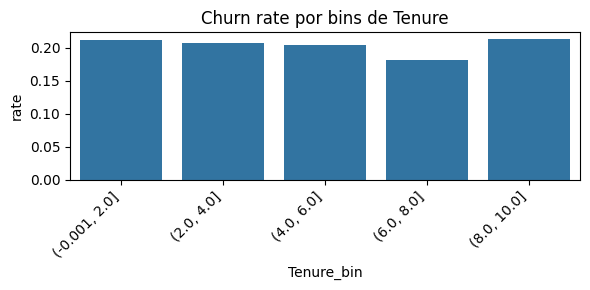

,Balance_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(-0.001, 73080.908]",4000,590,0.1475,0.136849,0.158827,14.75
1,"(73080.908, 110138.926]",2000,446,0.2230,0.205297,0.241765,22.30
2,"(110138.926, 133710.358]",2000,539,0.2695,0.250510,0.289374,26.95
3,"(133710.358, 250898.09]",2000,462,0.2310,0.213054,0.249977,23.10


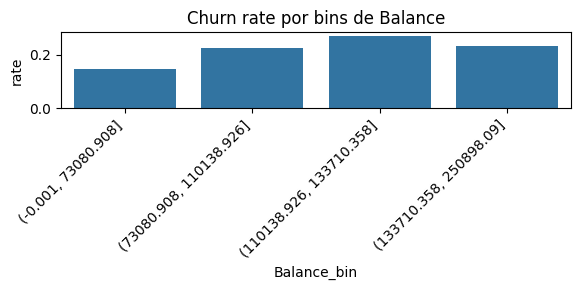

,NumOfProducts_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(0.999, 2.0]",9674,1757,0.181621,0.174065,0.189429,18.16
1,"(2.0, 4.0]",326,280,0.858896,0.816914,0.892518,85.89


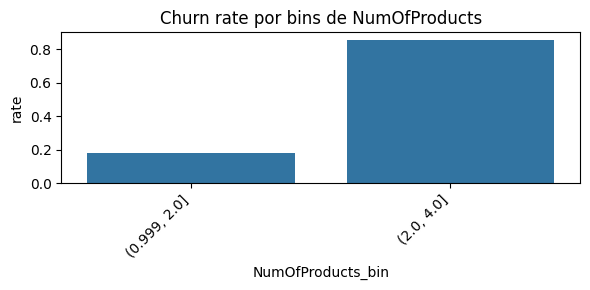

,HasCrCard_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(-0.001, 1.0]",10000,2037,0.2037,0.195921,0.211707,20.37


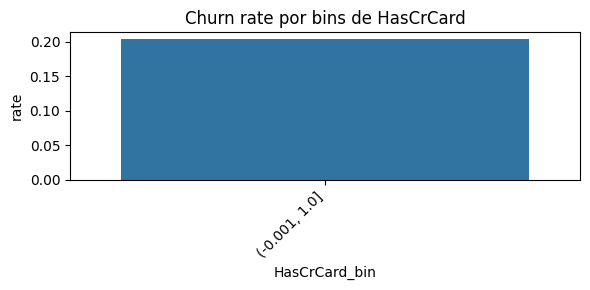

,IsActiveMember_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(-0.001, 1.0]",10000,2037,0.2037,0.195921,0.211707,20.37


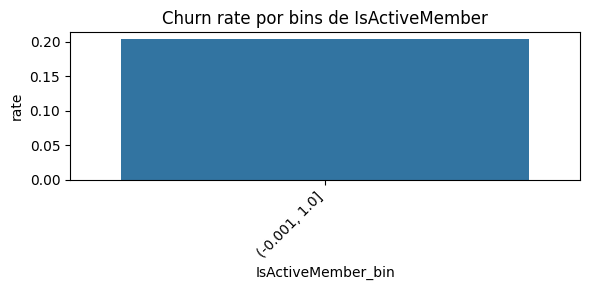

,EstimatedSalary_bin,n,churners,rate,ci95_low,ci95_high,rate_%
0,"(11.579, 41050.736]",2000,399,0.1995,0.182569,0.217583,19.95
1,"(41050.736, 80238.34]",2000,399,0.1995,0.182569,0.217583,19.95
2,"(80238.34, 119710.038]",2000,404,0.2020,0.184983,0.220160,20.20
3,"(119710.038, 159836.726]",2000,404,0.2020,0.184983,0.220160,20.20
4,"(159836.726, 199992.48]",2000,431,0.2155,0.198034,0.234057,21.55


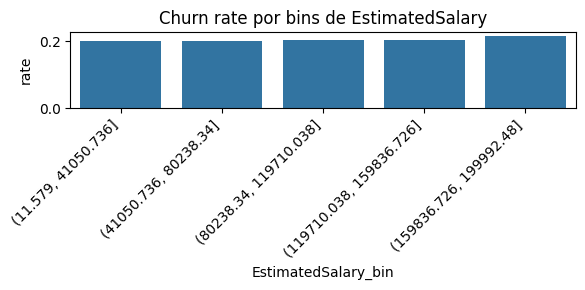

In [15]:
# --- Categóricas: tablas + gráficos ---
cat_tables = {}
for c in cat_cols:
    cat_tables[c] = churn_rate_by_category(df, c)

# --- Numéricas: tablas + gráficos por cuantiles ---
num_bin_tables = {}
for c in num_cols:
    try:
        num_bin_tables[c] = churn_rate_by_numeric_bins(df, c, q=5)
    except Exception as e:
        print(f"[WARN] No pude binnear {c}: {e}")